<a href="https://colab.research.google.com/github/aditigedam/ML/blob/main/Alzehimer'sANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 70 Apr 15 20:32 kaggle.json
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=18b92936c06d3ecf9d3eddb4fd16159fa3193b6b502eb5ac0e85e326cb58ca19
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 50% 17.0M/34.1M [00:00<00:00, 178MB/s]
100% 34.1M/34.1M [00:00<00:00, 225MB/s]


In [ ]:
!unzip alzheimers-dataset-4-class-of-images.zip

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array,load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 5
print(BATCH_SIZE)

16


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
#NUM_CLASSES = len(class_names)
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(class_names)
NUM_CLASSES = len(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


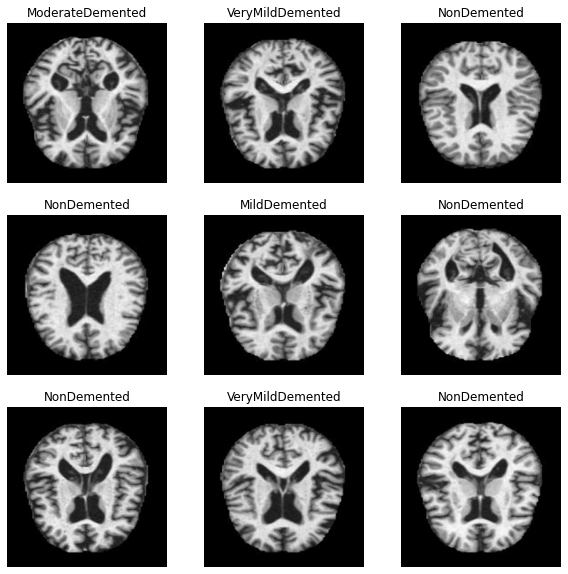

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
    print(images[i].numpy().shape)

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
NUM_IMAGES

[717, 52, 2560, 1792]

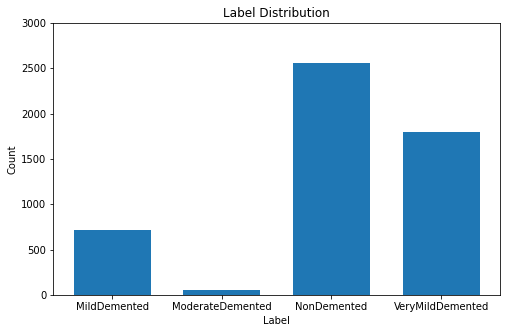

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.bar(class_names, NUM_IMAGES, width=0.7, align='center')
plt.title("Label Distribution")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(class_names)
plt.ylim(0, 3000)

# for a, b in zip(class_names, NUM_CLASSES):
#     plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [ ]:
model_normal= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

In [ ]:
model_normal.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_normal.fit(train_ds, batch_size=32, epochs=20, verbose=1,validation_data=val_ds)
score = model_normal.evaluate(val_ds, batch_size=100, verbose=10 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

Epoch 1/20
257/257 [==============================] - 28s 65ms/step - loss: 1.0605 - accuracy: 0.5150 - val_loss: 1.1186 - val_accuracy: 0.4951
Epoch 2/20
257/257 [==============================] - 16s 64ms/step - loss: 1.0341 - accuracy: 0.5240 - val_loss: 1.0251 - val_accuracy: 0.5127
Epoch 3/20
257/257 [==============================] - 17s 64ms/step - loss: 1.0092 - accuracy: 0.5282 - val_loss: 0.9974 - val_accuracy: 0.5225
Epoch 4/20
257/257 [==============================] - 17s 65ms/step - loss: 0.9886 - accuracy: 0.5489 - val_loss: 0.9959 - val_accuracy: 0.5225
Epoch 5/20
257/257 [==============================] - 16s 64ms/step - loss: 0.9666 - accuracy: 0.5450 - val_loss: 1.0553 - val_accuracy: 0.5010
Epoch 6/20
257/257 [==============================] - 16s 64ms/step - loss: 0.9394 - accuracy: 0.5567 - val_loss: 1.0797 - val_accuracy: 0.5088
Epoch 7/20
257/257 [==============================] - 16s 64ms/step - loss: 0.9225 - accuracy: 0.5785 - val_loss: 1.0821 - val_accuracy:

In [ ]:
num_classes = 4
#input shape
input_layer = Input(shape=(224, 224, 3))

#Use the VGG16 model 
model = VGG16(input_tensor=input_layer, include_top=True,weights='imagenet')

#Summary of the customize VGG16 model
model.summary()

In [ ]:
last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(input_layer, out)
custom_vgg_model.summary()

for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

In [ ]:
hist=custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


In [ ]:
hist = custom_vgg_model.fit(train_ds, batch_size=32, epochs=20, verbose=1,validation_data=val_ds)


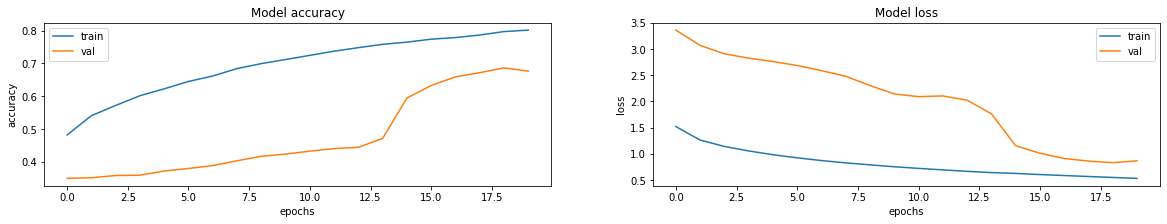

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
y_predicts = custom_vgg_model.predict(val_ds)
print(y_predicts)
y_predicts.shape

[[8.9119628e-02 3.0919213e-03 1.6459020e-02 8.9132935e-01]
 [9.4480604e-01 3.9607822e-13 3.3753904e-04 5.4856442e-02]
 [1.1643715e-04 3.9665625e-21 1.6513316e-02 9.8337030e-01]
 ...
 [1.5232121e-04 7.3078615e-14 4.8694542e-01 5.1290226e-01]
 [6.1300474e-01 3.0789488e-13 9.1296293e-02 2.9569900e-01]
 [1.2610484e-02 8.7952838e-32 3.8658860e-01 6.0080099e-01]]


(1024, 4)

In [ ]:
def decoder(val):
  class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
  return class_names[val]


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


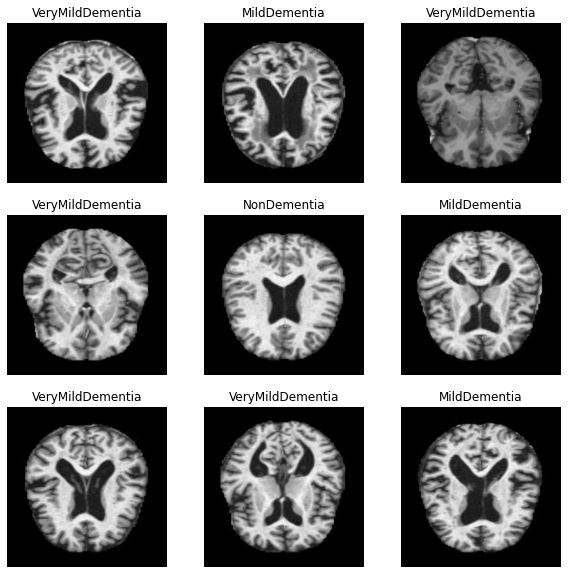

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(decoder(np.argmax(y_predicts[i])))
    plt.axis("off")
    print(images[i].numpy().shape)

Testing Images from Unseen Dataset

NonDementia


(-0.5, 223.5, 223.5, -0.5)

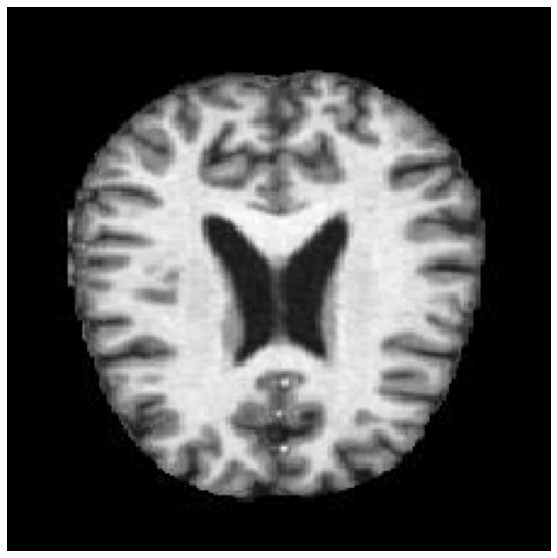

In [ ]:
images = image.load_img("Alzheimer_s Dataset/test/NonDemented/26 (100).jpg", target_size=( 224, 224))    
x = image.img_to_array(images)
x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
prediction=custom_vgg_model.predict(x)
print(decoder(np.argmax(prediction)))
plt.figure(figsize=(10, 10))
plt.imshow(x[0].astype("uint8"))
plt.axis("off")


[[3.2857275e-01 6.3297455e-05 4.1291073e-02 6.3007289e-01]]
VeryMildDementia


(-0.5, 223.5, 223.5, -0.5)

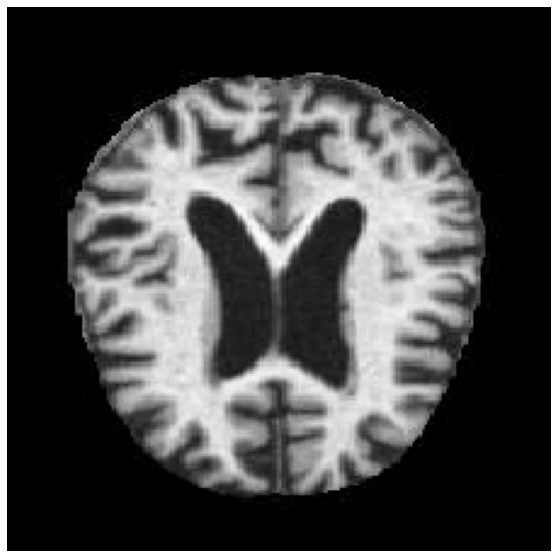

In [ ]:
images = image.load_img("Alzheimer_s Dataset/test/ModerateDemented/28 (2).jpg", target_size=( 224, 224))    
x = image.img_to_array(images)
x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
prediction=custom_vgg_model.predict(x)
print(prediction)
print(decoder(np.argmax(prediction)))
#Result=NonDementia
plt.figure(figsize=(10, 10))
plt.imshow(x[0].astype("uint8"))
# plt.title(decoder(np.argmax(y_predicts[i])))
plt.axis("off")
# print(images[i].numpy().shape)

In [ ]:
(loss, accuracy) = custom_vgg_model.evaluate(val_ds, batch_size=100, verbose=10)

In [ ]:
accuracy

0.6767578125

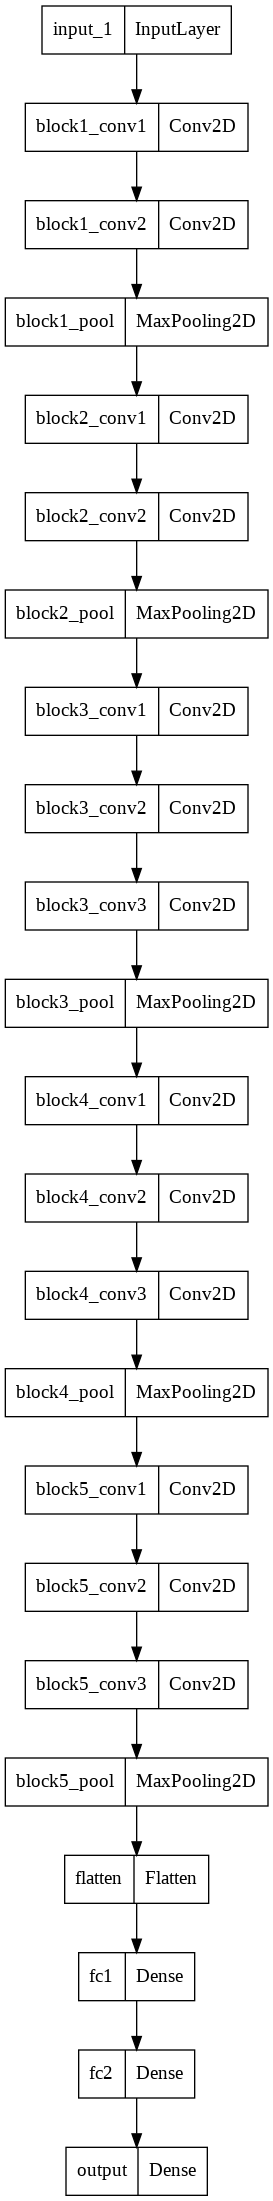

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(custom_vgg_model,to_file = 'plot.png')